<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmotionMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('all')
device_name = tf.test.gpu_device_name()
print(device_name)
df_train = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Newdata/train_clean.csv',names=['Tweet','Emotion'])
df_test = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Newdata/test_clean.csv',names=['Tweet','Emotion'])
df_train = df_train.sample(frac=1)
df_test = df_train.sample(frac=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading pack

In [ ]:
df_train.head(1000)

,Tweet,Emotion
6628,vivek whn r u goin to europ,2
8818,i miss my puppi,2
3325,iamdiddi it is so sad that me and my roommat f...,2
11965,got an email from my aunti bout father day mot...,1
2582,jalanii aww wat i wa go to buy myself someth p...,0
...,...,...
363,I am suppos to turn in a sentenc outlin for my...,2
1111,dam it keep rainin on me,2
4552,no u guy jonathanrknight said california in an...,0
5499,brookeleeadam gut you wont be on live offic gi...,2


In [ ]:
df_test.Emotion.unique()

array(['2', '1', '0', '3', 'emotion'], dtype=object)

In [ ]:
df_train.nunique()

Tweet      12370
Emotion        5
dtype: int64

In [ ]:
category_dict = {'0':[1,0,0,0],'1':[0,1,0,0],'2':[0,0,1,0],'3':[0,0,0,1],'emotion':[1,0,0,0]}
train_data_tweet = [x.lower().split() for x in df_train['Tweet']]
train_data_cat = np.array([category_dict[x] for x in df_train['Emotion']])
test_data_tweet = [x.lower().split() for x in df_test['Tweet']]
test_data_cat = np.array([category_dict[x] for x in df_test['Emotion']])

data_tweet = train_data_tweet + test_data_tweet

In [ ]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [ ]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [ ]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [ ]:
batch_size = 500
Max_input_size = max([len(x) for x in data_tweet])
mul_factor=1.5

In [ ]:
X_train = train_data_tweet
X_test = test_data_tweet
y_train = train_data_cat
y_test = test_data_cat
X_train = [nltk.pos_tag(x) for x in X_train]
X_test = [nltk.pos_tag(x) for x in X_test]
result_table = []

In [ ]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(w2v.wv.word_vec(i[0]),i[1]) for i in x if i[0] in vocab]
        l=len(tweet)
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='RB':
            tweet[i]=((tweet[i][0])*mul_factor,tweet[i][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)          
      
def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(vocab[i[0]],i[1]) for i in x if i[0] in vocab.keys()]
        l=len(tweet)
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='RB':
            tweet[i]=((tweet[i][0])*mul_factor,tweet[i][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

In [ ]:
epochs = 50

In [ ]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("SG_LSTM")


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
24/24 [==============================] - 5s 229ms/step - loss: 1.2434 - accuracy: 0.5723
Epoch 2/50
24/24 [==============================] - 6s 235ms/step - loss: 1.0211 - accuracy: 0.5845
Epoch 3/50
24/24 [==============================] - 6s 234ms/step - loss: 0.9859 - accuracy: 0.5845
Epoch 4/50
24/24 [==============================] - 6s 235ms/step - loss: 0.9838 - accuracy: 0.5845
Epoch 5/50
24/24 [==============================] - 6s 236ms/step - loss: 0.9797 - accuracy: 0.5845
Epoch 6/50
24/24 [==============================] - 6s 232ms/step - loss: 0.9754 - accuracy: 0.5845
Epoch 7/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9707 - accuracy: 0.5845
Epoch 8/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9666 - accuracy: 0.5845
Epoch 9/50
24/24 [==============================] - 6s 234ms/step - loss: 0.9643 - accuracy: 0.5845
Epoch 10/50
24/24 [=====

In [ ]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("SG_BI")

Epoch 1/50
24/24 [==============================] - 6s 234ms/step - loss: 1.2051 - accuracy: 0.5346
Epoch 2/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9903 - accuracy: 0.5845
Epoch 3/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9801 - accuracy: 0.5845
Epoch 4/50
24/24 [==============================] - 6s 234ms/step - loss: 0.9760 - accuracy: 0.5845
Epoch 5/50
24/24 [==============================] - 6s 237ms/step - loss: 0.9710 - accuracy: 0.5846
Epoch 6/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9648 - accuracy: 0.5846
Epoch 7/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9587 - accuracy: 0.5847
Epoch 8/50
24/24 [==============================] - 6s 234ms/step - loss: 0.9524 - accuracy: 0.5848
Epoch 9/50
24/24 [==============================] - 6s 237ms/step - loss: 0.9472 - accuracy: 0.5851
Epoch 10/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9433 - accuracy: 0.5848

In [ ]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("SG_RNN")

Epoch 1/50
24/24 [==============================] - 6s 243ms/step - loss: 1.1231 - accuracy: 0.5298
Epoch 2/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9963 - accuracy: 0.5837
Epoch 3/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9887 - accuracy: 0.5844
Epoch 4/50
24/24 [==============================] - 6s 246ms/step - loss: 0.9879 - accuracy: 0.5844
Epoch 5/50
24/24 [==============================] - 6s 249ms/step - loss: 0.9878 - accuracy: 0.5844
Epoch 6/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9879 - accuracy: 0.5844
Epoch 7/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9880 - accuracy: 0.5844
Epoch 8/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9880 - accuracy: 0.5844
Epoch 9/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9880 - accuracy: 0.5844
Epoch 10/50
24/24 [==============================] - 6s 241ms/step - loss: 0.9879 - accuracy: 0.5844

In [ ]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_lstm = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("CBOW_LSTM")

Epoch 1/50
24/24 [==============================] - 6s 234ms/step - loss: 1.2140 - accuracy: 0.5712
Epoch 2/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9914 - accuracy: 0.5845
Epoch 3/50
24/24 [==============================] - 6s 237ms/step - loss: 0.9832 - accuracy: 0.5845
Epoch 4/50
24/24 [==============================] - 5s 228ms/step - loss: 0.9798 - accuracy: 0.5845
Epoch 5/50
24/24 [==============================] - 6s 234ms/step - loss: 0.9758 - accuracy: 0.5845
Epoch 6/50
24/24 [==============================] - 6s 232ms/step - loss: 0.9718 - accuracy: 0.5845
Epoch 7/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9672 - accuracy: 0.5845
Epoch 8/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9639 - accuracy: 0.5845
Epoch 9/50
24/24 [==============================] - 6s 235ms/step - loss: 0.9618 - accuracy: 0.5847
Epoch 10/50
24/24 [==============================] - 6s 229ms/step - loss: 0.9592 - accuracy: 0.5846

In [ ]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("CBOW_BI")

Epoch 1/50
24/24 [==============================] - 6s 237ms/step - loss: 1.1908 - accuracy: 0.5572
Epoch 2/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9883 - accuracy: 0.5845
Epoch 3/50
24/24 [==============================] - 6s 244ms/step - loss: 0.9768 - accuracy: 0.5845
Epoch 4/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9709 - accuracy: 0.5845
Epoch 5/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9647 - accuracy: 0.5847
Epoch 6/50
24/24 [==============================] - 6s 237ms/step - loss: 0.9594 - accuracy: 0.5848
Epoch 7/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9544 - accuracy: 0.5849
Epoch 8/50
24/24 [==============================] - 6s 246ms/step - loss: 0.9495 - accuracy: 0.5863
Epoch 9/50
24/24 [==============================] - 6s 241ms/step - loss: 0.9449 - accuracy: 0.5867
Epoch 10/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9404 - accuracy: 0.5878

In [ ]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("CBOW_RNN")

Epoch 1/50
24/24 [==============================] - 6s 259ms/step - loss: 1.1009 - accuracy: 0.5318
Epoch 2/50
24/24 [==============================] - 6s 258ms/step - loss: 0.9902 - accuracy: 0.5842
Epoch 3/50
24/24 [==============================] - 6s 253ms/step - loss: 0.9887 - accuracy: 0.5844
Epoch 4/50
24/24 [==============================] - 6s 256ms/step - loss: 0.9880 - accuracy: 0.5845
Epoch 5/50
24/24 [==============================] - 6s 253ms/step - loss: 0.9881 - accuracy: 0.5844
Epoch 6/50
24/24 [==============================] - 6s 251ms/step - loss: 0.9877 - accuracy: 0.5845
Epoch 7/50
24/24 [==============================] - 6s 254ms/step - loss: 0.9877 - accuracy: 0.5846
Epoch 8/50
24/24 [==============================] - 6s 254ms/step - loss: 0.9876 - accuracy: 0.5845
Epoch 9/50
24/24 [==============================] - 6s 257ms/step - loss: 0.9875 - accuracy: 0.5846
Epoch 10/50
24/24 [==============================] - 6s 252ms/step - loss: 0.9877 - accuracy: 0.5845

In [ ]:
epochs=50
Embedding_size=100

In [ ]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_lstm = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("GLOVE_LSTM")


Epoch 1/50
24/24 [==============================] - 1s 42ms/step - loss: 1.2085 - accuracy: 0.5832
Epoch 2/50
24/24 [==============================] - 1s 42ms/step - loss: 1.0015 - accuracy: 0.5845
Epoch 3/50
24/24 [==============================] - 1s 42ms/step - loss: 0.9809 - accuracy: 0.5846
Epoch 4/50
24/24 [==============================] - 1s 41ms/step - loss: 0.9736 - accuracy: 0.5846
Epoch 5/50
24/24 [==============================] - 1s 42ms/step - loss: 0.9678 - accuracy: 0.5838
Epoch 6/50
24/24 [==============================] - 1s 42ms/step - loss: 0.9573 - accuracy: 0.5900
Epoch 7/50
24/24 [==============================] - 1s 42ms/step - loss: 0.9374 - accuracy: 0.5969
Epoch 8/50
24/24 [==============================] - 1s 42ms/step - loss: 0.9120 - accuracy: 0.6047
Epoch 9/50
24/24 [==============================] - 1s 43ms/step - loss: 0.8966 - accuracy: 0.6076
Epoch 10/50
24/24 [==============================] - 1s 43ms/step - loss: 0.8831 - accuracy: 0.6125
Epoch 11/

In [ ]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("GLOVE_BI")

Epoch 1/50
24/24 [==============================] - 1s 44ms/step - loss: 1.0573 - accuracy: 0.5770
Epoch 2/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9627 - accuracy: 0.5851
Epoch 3/50
24/24 [==============================] - 1s 45ms/step - loss: 0.9385 - accuracy: 0.5872
Epoch 4/50
24/24 [==============================] - 1s 47ms/step - loss: 0.9131 - accuracy: 0.5982
Epoch 5/50
24/24 [==============================] - 1s 46ms/step - loss: 0.8974 - accuracy: 0.6068
Epoch 6/50
24/24 [==============================] - 1s 45ms/step - loss: 0.8838 - accuracy: 0.6122
Epoch 7/50
24/24 [==============================] - 1s 46ms/step - loss: 0.8728 - accuracy: 0.6177
Epoch 8/50
24/24 [==============================] - 1s 46ms/step - loss: 0.8627 - accuracy: 0.6230
Epoch 9/50
24/24 [==============================] - 1s 46ms/step - loss: 0.8530 - accuracy: 0.6288
Epoch 10/50
24/24 [==============================] - 1s 45ms/step - loss: 0.8428 - accuracy: 0.6369
Epoch 11/

In [ ]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("GLOVE_RNN")

Epoch 1/50
24/24 [==============================] - 2s 64ms/step - loss: 1.1293 - accuracy: 0.5365
Epoch 2/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9940 - accuracy: 0.5842
Epoch 3/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9816 - accuracy: 0.5844
Epoch 4/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9763 - accuracy: 0.5859
Epoch 5/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9698 - accuracy: 0.5874
Epoch 6/50
24/24 [==============================] - 1s 62ms/step - loss: 0.9669 - accuracy: 0.5897
Epoch 7/50
24/24 [==============================] - 1s 62ms/step - loss: 0.9616 - accuracy: 0.5939
Epoch 8/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9575 - accuracy: 0.5960
Epoch 9/50
24/24 [==============================] - 1s 62ms/step - loss: 0.9515 - accuracy: 0.5988
Epoch 10/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9468 - accuracy: 0.6019
Epoch 11/

	Lstm			BiLstm			Rnn
sg [0.6852499842643738, 0.7020833492279053, 0.5857499837875366]
cbow [0.7177500128746033, 0.7506666779518127, 0.5955833196640015]
glove [0.762583315372467, 0.7919999957084656, 0.6758333444595337]
{'loss': [1.2051223516464233, 0.9903011322021484, 0.9800624251365662, 0.9760096669197083, 0.9709927439689636, 0.9647576212882996, 0.9587016701698303, 0.952382504940033, 0.9472473859786987, 0.9433058500289917, 0.9396315813064575, 0.9366110563278198, 0.9349943995475769, 0.9348272085189819, 0.9313245415687561, 0.9242314696311951, 0.9177142977714539, 0.9134690761566162, 0.9083897471427917, 0.902794599533081, 0.8970194458961487, 0.8908019065856934, 0.8839716911315918, 0.87664794921875, 0.8719397783279419, 0.8718796372413635, 0.8585988879203796, 0.8515133261680603, 0.8418104648590088, 0.8345919847488403, 0.8267427682876587, 0.8197890520095825, 0.8090539574623108, 0.7970016002655029, 0.7876979112625122, 0.790432870388031, 0.8092682361602783, 0.8168262243270874, 0.7934706211090088

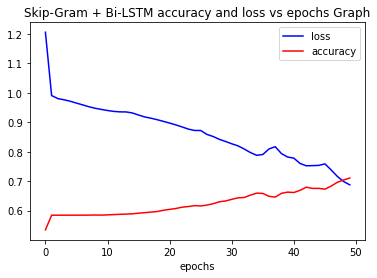

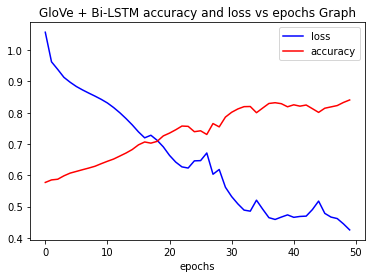

In [ ]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()